## 🔍 Clusterização de Dispositivos

Após a análise exploratória dos dados do projeto PhoneDex, esta seção tem como objetivo aplicar técnicas de **aprendizado não supervisionado**, mais especificamente **algoritmos de clusterização**, para agrupar os dispositivos móveis com base em características semelhantes.

O propósito é identificar agrupamentos naturais entre os smartphones, considerando variáveis como preço, bateria, armazenamento, marca, entre outras. Esses agrupamentos podem ajudar a entender padrões de mercado, posicionamento de produtos e preferências dos consumidores ao longo do tempo.

A seguir, realizaremos o pré-processamento dos dados, normalização das variáveis relevantes e aplicação de algoritmos como **K-Means** para descobrir insights úteis.

### **Carregamento e limpeza dos dados**

Os dados são lidos de um arquivo `.xlsx`, com limpeza de colunas textuais e criação de colunas numéricas derivadas, como `Preço (R$)` e `Bateria (mAh)`.

In [77]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Display settings
plt.rcParams.update({"axes.labelsize": 11, "axes.titlesize": 13, "figure.autolayout": True})
sns.set_style("whitegrid")

# Set this to your Excel file path
EXCEL_FILE = "D:/Projetos/faculdade/PISI3GP6/datasets/pisi3basededados.xlsx"


In [78]:

cotacao_dolar = 5.68  # adjust if needed

df = pd.read_excel(EXCEL_FILE)
df.columns = df.columns.str.strip()

# Basic cleaning and new columns
df["Preço (USD)"] = (
    df["Launched Price (USA)"]
    .astype(str)
    .str.replace("USD", "", regex=False)
    .str.replace(",", "", regex=False)
    .astype(float)
)

df["Preço (R$)"] = df["Preço (USD)"] * cotacao_dolar
df["Ano"] = df["Launched Year"]
df["Marca"] = df["Company Name"]
df["Sistema Operacional"] = df["Sistema Operacional"].astype(str).str.strip()
df["Sistema Operacional (Binário)"] = np.where(df["Sistema Operacional"].str.lower().str.contains("android"), 0, 1).astype(int)
df["Peso (g)"] = df["Mobile Weight"].astype(str).str.replace("g", "", regex=False).astype(float)
df["Memoria Interna (GB)"] = (
    df["RAM"]
    .astype(str)
    .str.replace("GB", "", regex=False)
    .str.replace(r"/.*", "", regex=True)  # Remove tudo após "/"
    .str.strip()
    .astype(float)
)
df["Câmera Frontal (MP)"] = (
    df["Front Camera"]
    .astype(str)
    .str.replace("MP", "", regex=False)
    .str.replace("Dual ", "", regex=False)  # Remove tudo após "/"
    .str.replace(r"/.*", "", regex=True)  # Remove tudo após "/"
    .str.replace(r"\+.*", "", regex=True)  # Remove tudo após "+"
    .str.replace(r",.*", "", regex=True)  # Remove tudo após ","
    .str.replace(r"\(.*?\)", "", regex=True)  # Remove tudo entre "()"
    .str.strip()
    .astype(float)
)
df["Câmera Traseira (MP)"] = (
    df["Back Camera"]
    .astype(str)
    .str.replace("MP", "", regex=False)
    .str.replace("Dual ", "", regex=False)  # Remove tudo após "/"
    .str.replace(r"/.*", "", regex=True)  # Remove tudo após "/"
    .str.replace(r"\+.*", "", regex=True)  # Remove tudo após "+"
    .str.replace(r",.*", "", regex=True)  # Remove tudo após ","
    .str.replace(r"\(.*?\)", "", regex=True)  # Remove tudo entre "()"
    .str.strip()
    .astype(float)
)
df["Tela (polegadas)"] = (
    df["Screen Size"]
    .astype(str)
    .str.replace(" inches", "", regex=False)
    .str.replace(r",.*", "", regex=True)  # Remove tudo após ","
    .str.replace(r"\(.*?\)", "", regex=True)  # Remove tudo entre "()"
    .astype(float)
)
df["Bateria (mAh)"] = (
    df["Battery Capacity"]
    .astype(str)
    .str.replace("mAh", "", regex=False)
    .str.replace(",", "", regex=False)
    .astype(float)
)

# Remove unnecessary columns
df.drop(
    columns=[
        "Mobile Weight",
        "Launched Price (USA)",
        "Battery Capacity",
        "RAM",
        "Front Camera",
        "Back Camera",
        "Screen Size",
        "Launched Year",
        "Company Name",
    ],
    inplace=True
)

print("Dataset shape:", df.shape)
df.head()

Dataset shape: (373, 14)


,Model Name,Processor,Sistema Operacional,Preço (USD),Preço (R$),Ano,Marca,Sistema Operacional (Binário),Peso (g),Memoria Interna (GB),Câmera Frontal (MP),Câmera Traseira (MP),Tela (polegadas),Bateria (mAh)
0,iPhone 16 128GB,A17 Bionic,iOS,799.0,4538.32,2024,Apple,1,174.0,6.0,12.0,48.0,6.1,3600.0
1,iPhone 16 256GB,A17 Bionic,iOS,849.0,4822.32,2024,Apple,1,174.0,6.0,12.0,48.0,6.1,3600.0
2,iPhone 16 512GB,A17 Bionic,iOS,899.0,5106.32,2024,Apple,1,174.0,6.0,12.0,48.0,6.1,3600.0
3,iPhone 16 Plus 128GB,A17 Bionic,iOS,899.0,5106.32,2024,Apple,1,203.0,6.0,12.0,48.0,6.7,4200.0
4,iPhone 16 Plus 256GB,A17 Bionic,iOS,949.0,5390.32,2024,Apple,1,203.0,6.0,12.0,48.0,6.7,4200.0


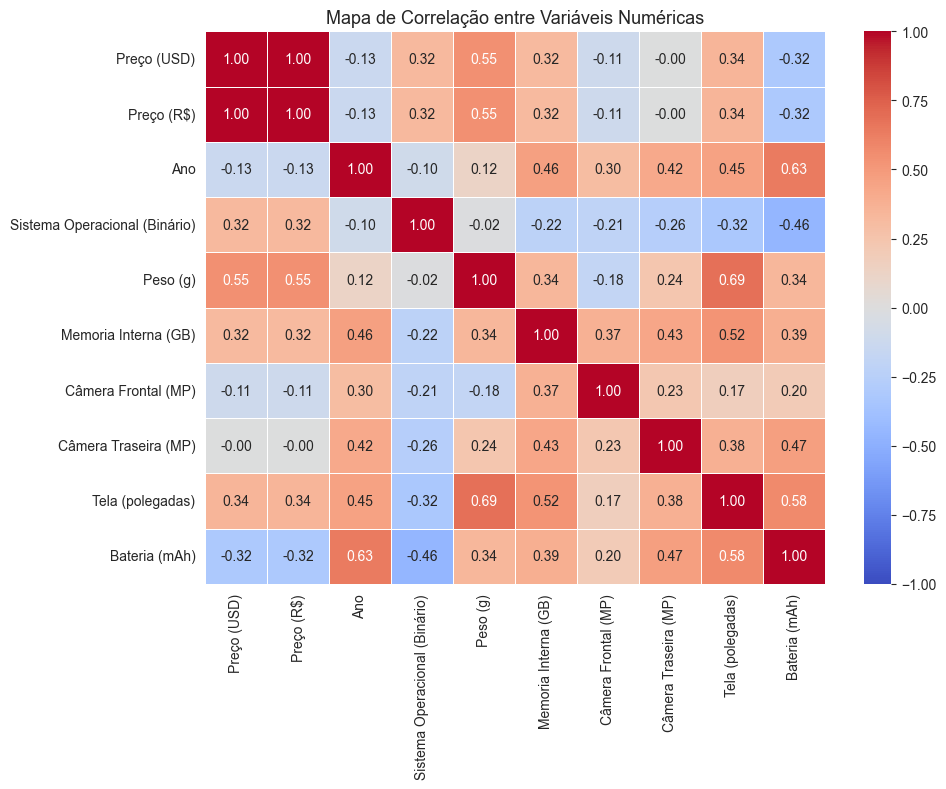

In [79]:
# Selecionar apenas colunas numéricas
numeric_cols = df.select_dtypes(include=['int64', 'float64'])

# Calcular a matriz de correlação
corr = numeric_cols.corr()

# Plotar o heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr, 
    annot=True, 
    cmap='coolwarm', 
    fmt=".2f", 
    linewidths=0.5, 
    vmin=-1, vmax=1  # Escala explícita de -1 a 1
)
plt.title('Mapa de Correlação entre Variáveis Numéricas')
plt.show()

### **Seleção de variáveis e padronização dos dados**

In [80]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Seleção das variáveis
features_for_clustering = [
    "Preço (R$)", 
    "Bateria (mAh)", 
    "Peso (g)", 
    "Memoria Interna (GB)", 
    "Câmera Frontal (MP)", 
    "Câmera Traseira (MP)", 
    "Tela (polegadas)"
]

df_clustering = df[features_for_clustering].copy()

# Padronização
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_clustering)

print("\n=== Variáveis utilizadas para clusterização: ===")
for feature in df_clustering:
    print(f"- {feature}")


=== Variáveis utilizadas para clusterização: ===
- Preço (R$)
- Bateria (mAh)
- Peso (g)
- Memoria Interna (GB)
- Câmera Frontal (MP)
- Câmera Traseira (MP)
- Tela (polegadas)


### **Redução de dimensionalidade para visualização com PCA**

In [81]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df['PCA1'] = X_pca[:, 0]
df['PCA2'] = X_pca[:, 1]

### **Visualização exploratória com 3 clusters**

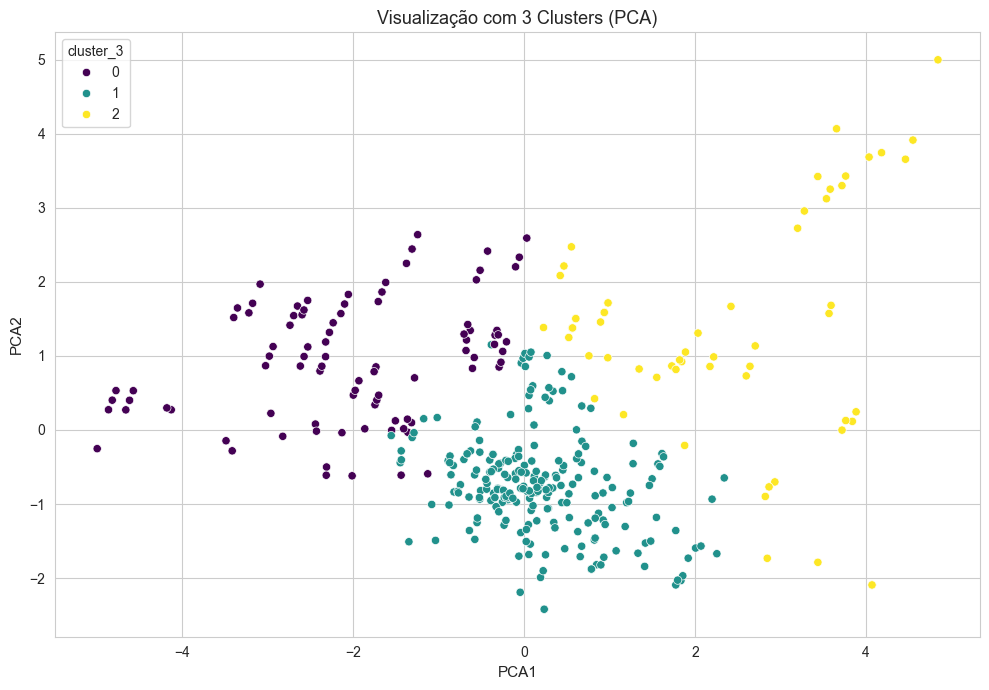

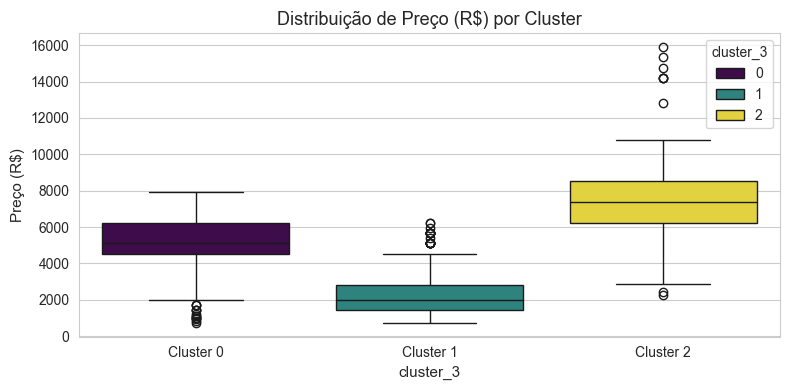

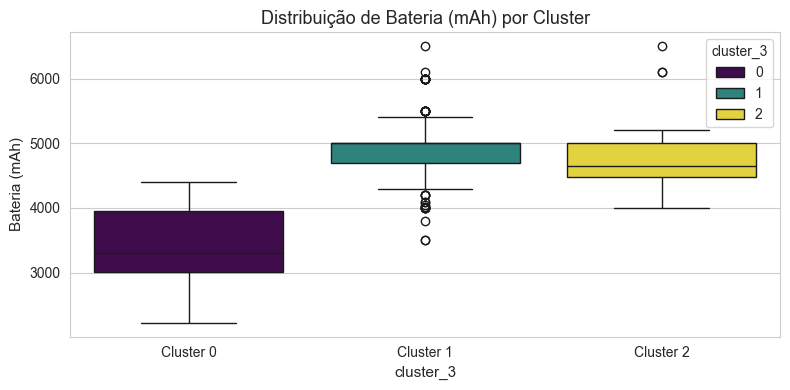

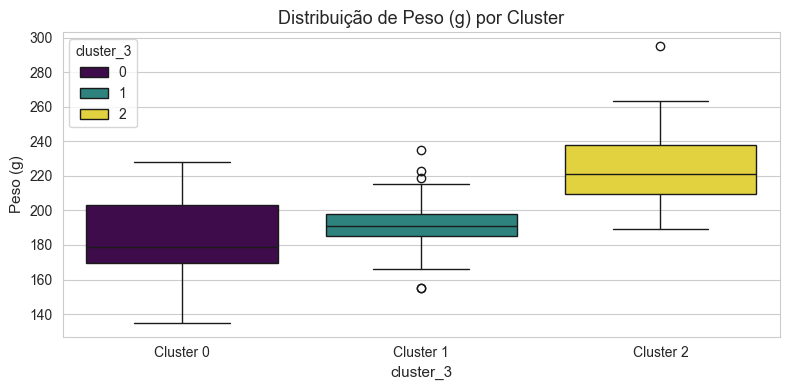

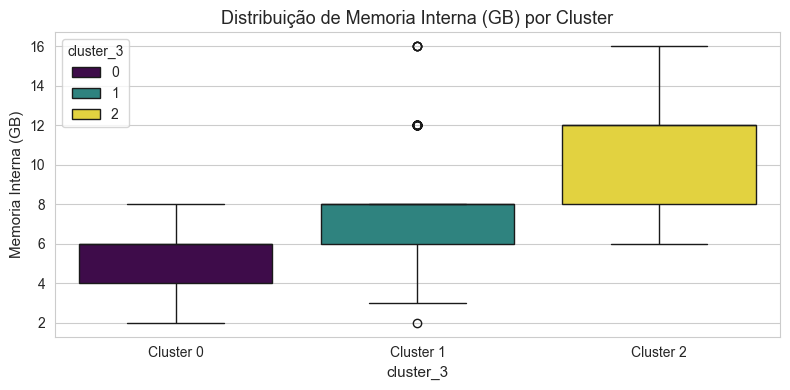

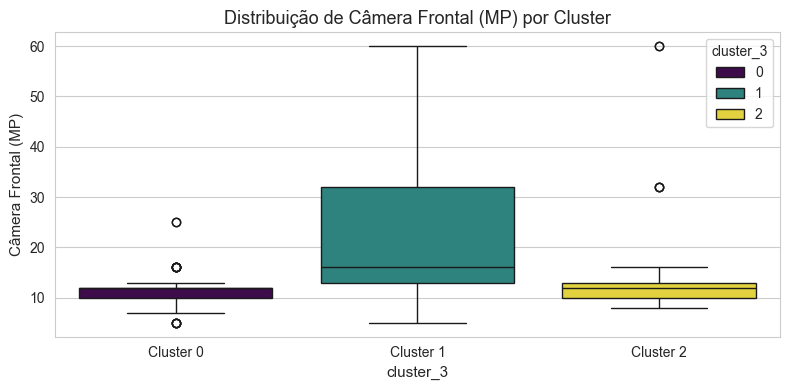

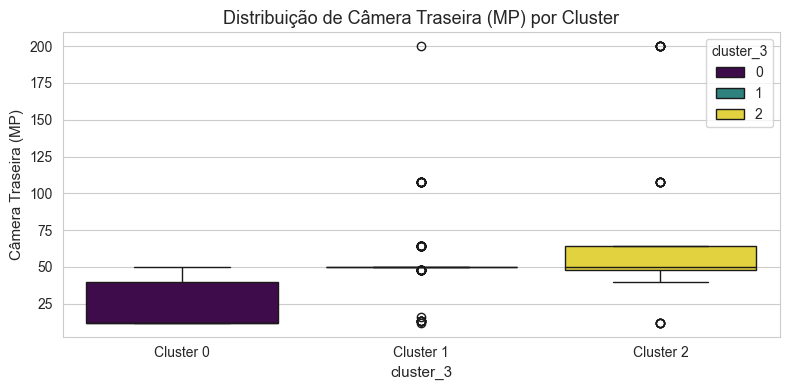

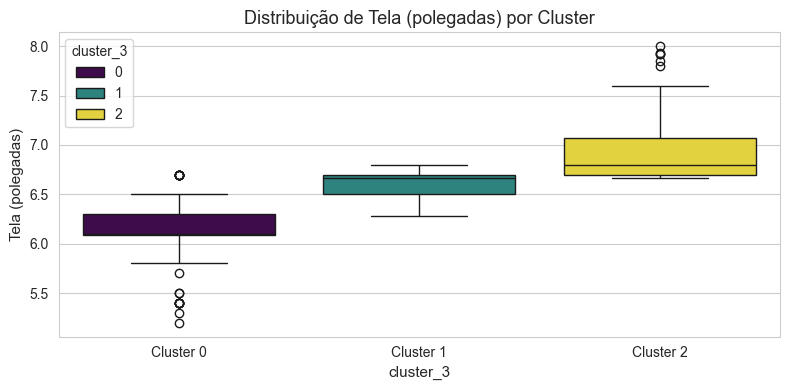

In [82]:
# KMeans com k=3
kmeans_3 = KMeans(n_clusters=3, random_state=42, n_init=10)
df['cluster_3'] = kmeans_3.fit_predict(X_scaled)

# Gráfico
plt.figure(figsize=(10, 7))
sns.scatterplot(x=df["PCA1"], y=df["PCA2"], hue=df["cluster_3"], palette='viridis')
plt.title('Visualização com 3 Clusters (PCA)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.grid(True)
plt.show()

for col in features_for_clustering:
    # Visualização dos clusters em relação ao preço e memória interna
    plt.figure(figsize=(8, 4))
    sns.boxplot(x="cluster_3", y=col, hue="cluster_3", data=df, palette='viridis')
    plt.title(f'Distribuição de {col} por Cluster')
    plt.xticks(ticks=range(3), labels=[f'Cluster {i}' for i in range(3)])
    plt.show()


### **Determinação do número ótimo de clusters (método do cotovelo e silhueta)**

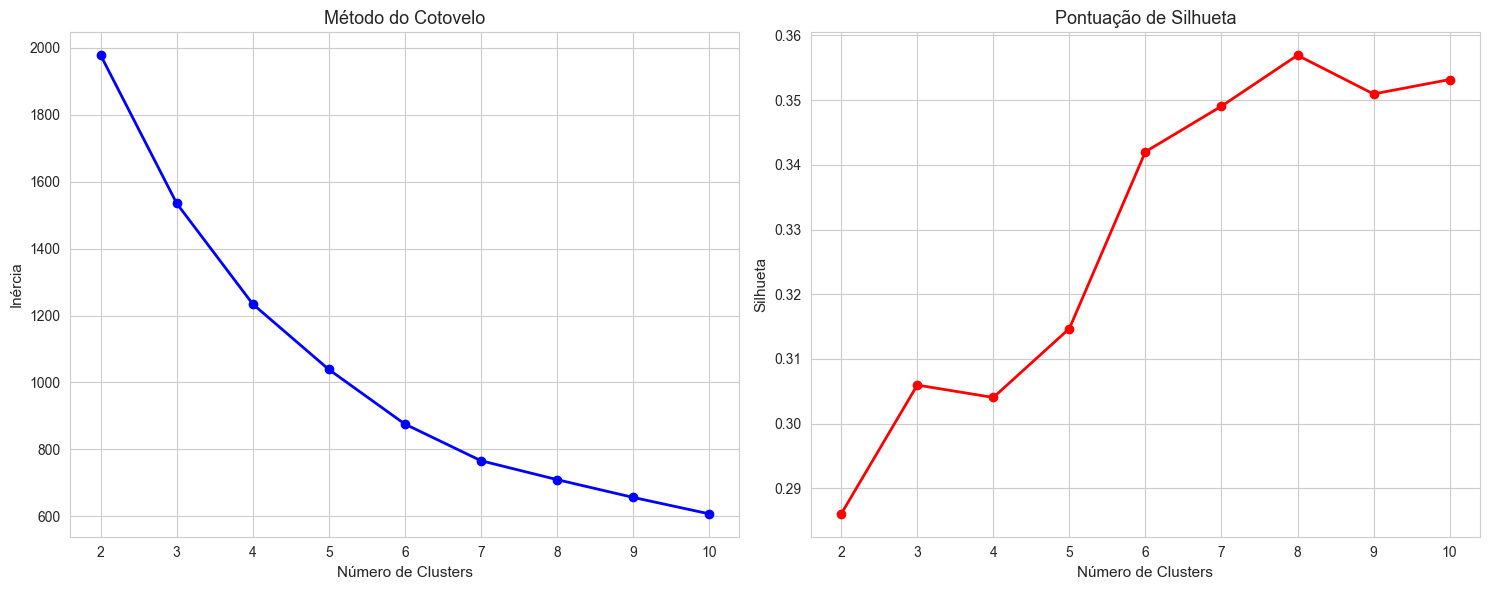

Número ótimo de clusters baseado na silhueta: 8


In [83]:
inertias = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Plot dos métodos
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
ax1.plot(K_range, inertias, 'bo-', linewidth=2)
ax1.set_title('Método do Cotovelo')
ax1.set_xlabel('Número de Clusters')
ax1.set_ylabel('Inércia')
ax1.grid(True)

ax2.plot(K_range, silhouette_scores, 'ro-', linewidth=2)
ax2.set_title('Pontuação de Silhueta')
ax2.set_xlabel('Número de Clusters')
ax2.set_ylabel('Silhueta')
ax2.grid(True)

plt.tight_layout()
plt.show()

# Determinação do k ótimo
optimal_k = K_range[np.argmax(silhouette_scores)]
print(f"Número ótimo de clusters baseado na silhueta: {optimal_k}")

### **Aplicação final do K-Means com k ótimo**

In [84]:
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['cluster_k'] = kmeans_final.fit_predict(X_scaled)

### **Análise dos clusters (estatísticas e contagem)**

In [85]:
print("Distribuição por cluster:")
print(df['cluster_k'].value_counts())

print("\nMédia dos atributos por cluster:")
print(df.groupby('cluster_k')[features_for_clustering].mean())

Distribuição por cluster:
cluster_k
3    115
2     64
1     63
6     49
4     39
0     19
5     15
7      9
Name: count, dtype: int64

Média dos atributos por cluster:
             Preço (R$)  Bateria (mAh)    Peso (g)  Memoria Interna (GB)  \
cluster_k                                                                  
0           3563.751579    5118.947368  200.684211              8.736842   
1           6134.129524    4237.634921  207.523810              7.015873   
2           4281.832500    3202.812500  173.468750              4.890625   
3           1498.482783    5085.000000  192.954783              5.878261   
4           4062.330174    5285.897436  204.758974             12.923077   
5          12028.346667    4566.666667  248.533333             11.466667   
6           3117.740408    4501.632653  179.387755              8.938776   
7           5804.265778    5036.666667  215.000000             12.000000   

           Câmera Frontal (MP)  Câmera Traseira (MP)  Tela (polegadas) 

### **Visualização dos clusters**

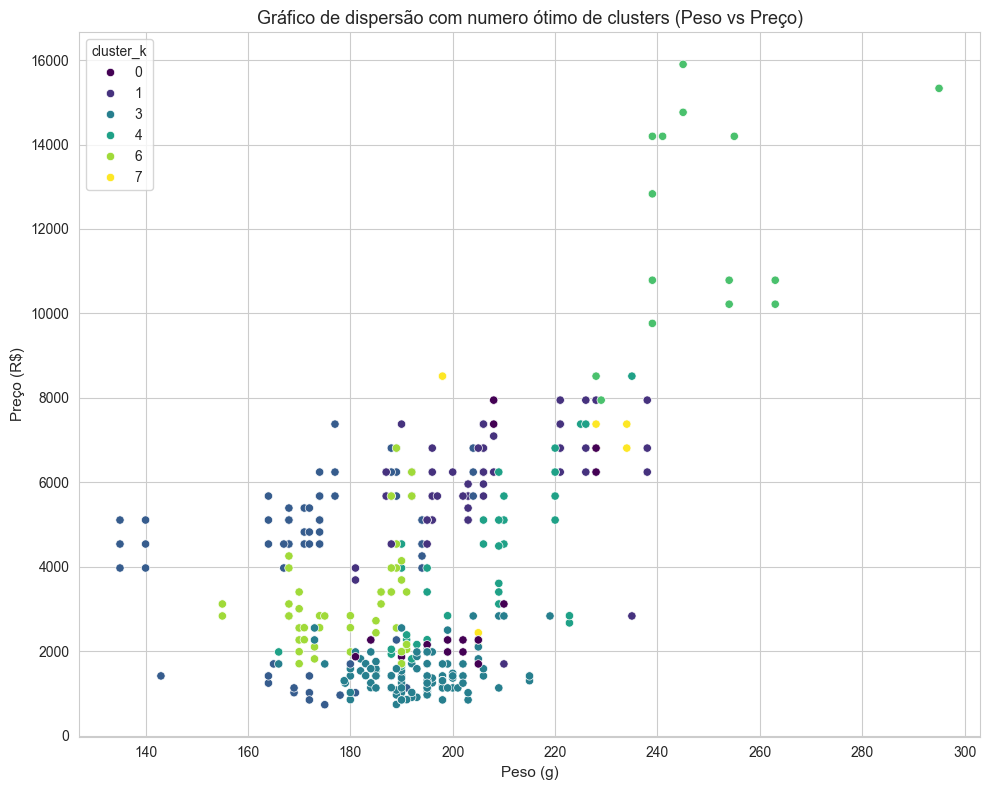

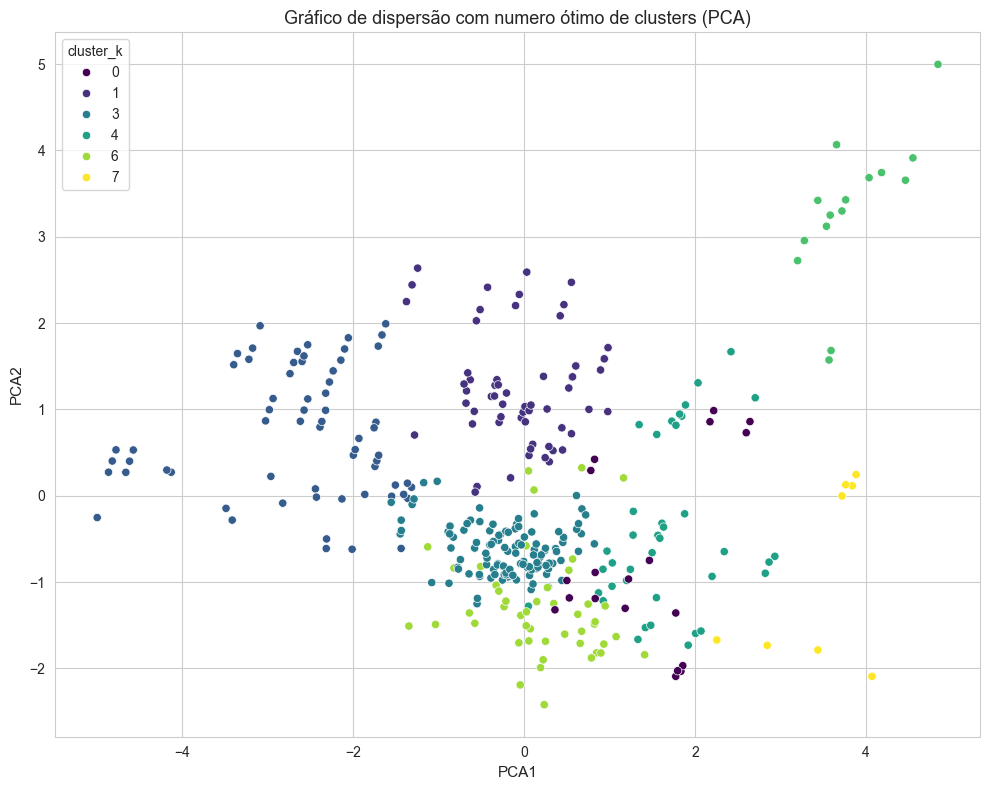

In [93]:

plt.figure(figsize=(10, 8))
sns.scatterplot(x="Peso (g)", y="Preço (R$)", hue="cluster_k", data=df, palette='viridis')
plt.title('Gráfico de dispersão com numero ótimo de clusters (Peso vs Preço)')
plt.show()

plt.figure(figsize=(10, 8))
sns.scatterplot(x='PCA1', y='PCA2', hue='cluster_k', data=df, palette='viridis')
plt.title('Gráfico de dispersão com numero ótimo de clusters (PCA)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.show()

### **Boxplots das variáveis por cluster**

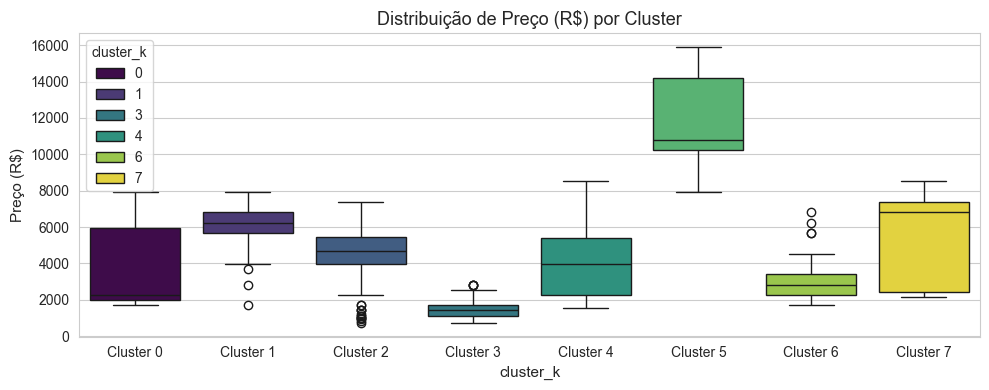

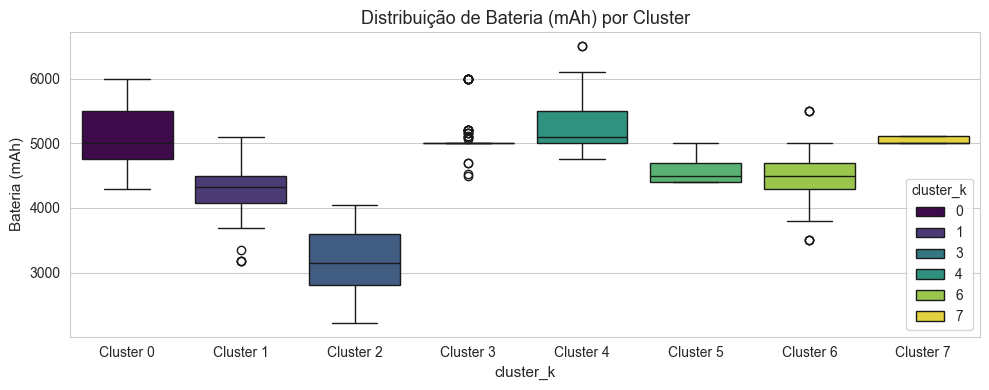

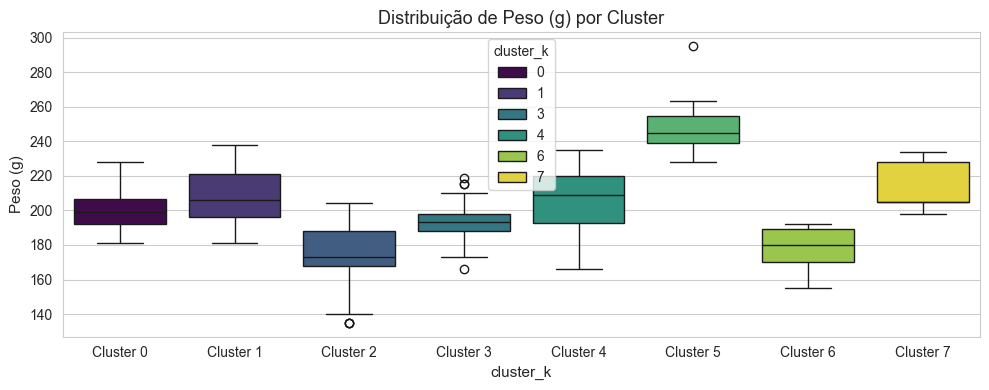

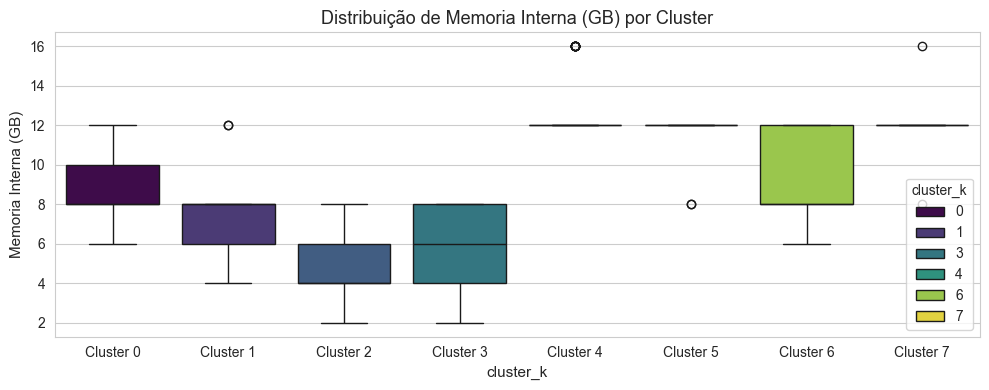

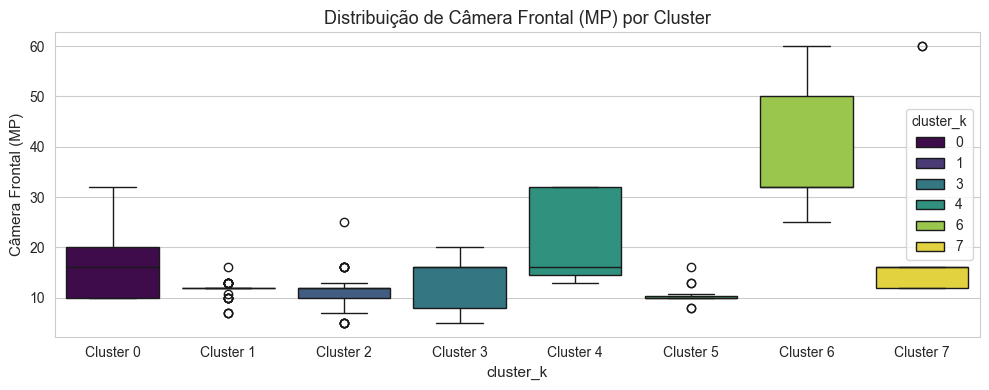

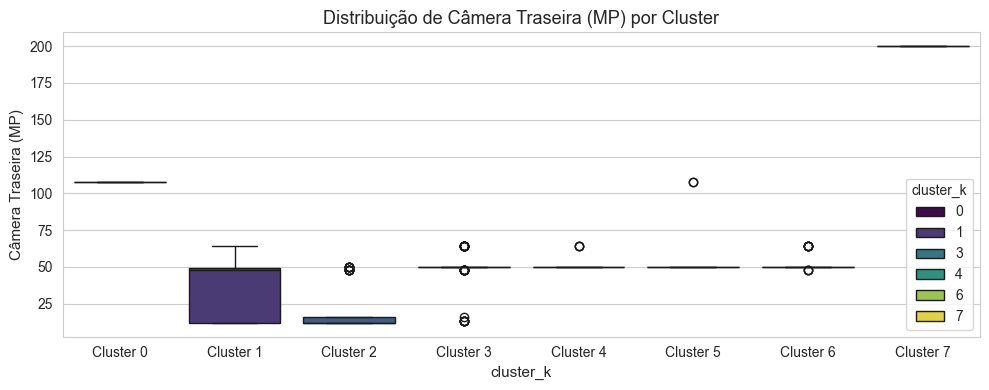

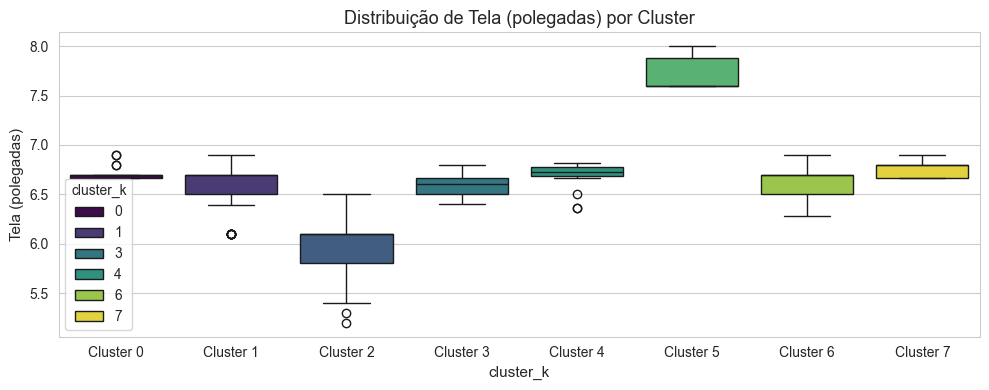

In [87]:
for col in features_for_clustering:
    # Visualização dos clusters em relação ao preço e memória interna
    plt.figure(figsize=(10, 4))
    sns.boxplot(x="cluster_k", y=col, hue="cluster_k", data=df, palette='viridis')
    plt.title(f'Distribuição de {col} por Cluster')
    plt.xticks(ticks=range(optimal_k), labels=[f'Cluster {i}' for i in range(optimal_k)])
    plt.show()

### **Mapa de calor da contagem de SO por cluster**

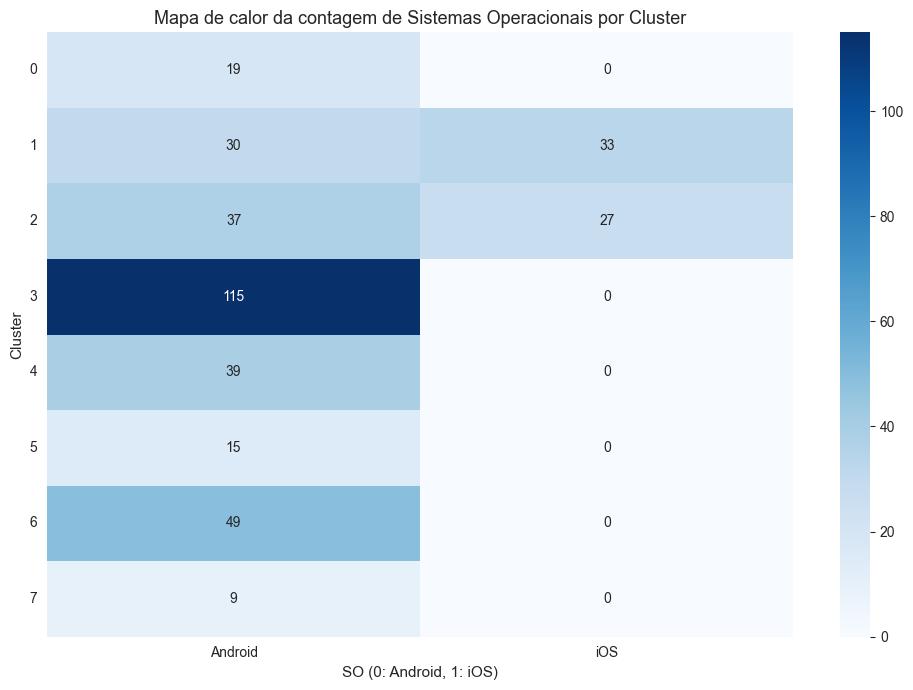

In [94]:
df_so_cluster = df.groupby('cluster_k')['Sistema Operacional (Binário)'].value_counts().unstack(fill_value=0)

df_so_cluster.rename(columns={0.0: 'Android', 1.0: 'iOS'}, inplace=True)

plt.figure(figsize=(10, 7))
sns.heatmap(df_so_cluster, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.title('Mapa de calor da contagem de Sistemas Operacionais por Cluster')
plt.xlabel('SO (0: Android, 1: iOS)')
plt.ylabel('Cluster')
plt.yticks(rotation=0)
plt.show()